Import all necessary libraries

In [1]:
using Plots
using Zygote
using RDatasets
using Flux
using Random
using Statistics

Define activation function and its derivative

In [2]:
function sigmoid(x)
    return 1.0/(1.0+exp(-x))
end

function sigm_der(x)
    return sigmoid(x)*(1.0-sigmoid(x))
end

sigm_der (generic function with 1 method)

Backpropagation from previous file

In [3]:
function backprop(X, Y, weights, biases)
    n_lay = size(weights)[1]
    
    # 1. calculate activations (and pre-activations) of every model layer
    # starting from input and propagating to the end
    
    preacts = []#Array{Array{Float64}}[]
    acts = []#Array{Array{Float64}}[]
    
    prev_act = X
    for i in 1:n_lay
        preact = weights[i]*prev_act+biases[i]
        prev_act = sigmoid.(preact)
        push!(preacts, preact)
        push!(acts, prev_act)
    end
    
    # 2. calculate gradients of loss w.r.t. layer activations
    
    deltas = []
    δ_prev = loss_gradient(Y, acts[end])
    push!(deltas, δ_prev)
    
    # now iterating backwards, i.e. propagating gradients from last layer to the first,
    # starting from the gradient of loss w.r.t. NN output
    
    for i in reverse(1:n_lay)
        δ = transpose(weights[i])*(δ_prev.*sigm_der.(preacts[i]))
        push!(deltas, δ)
        δ_prev = δ
    end
    reverse!(deltas)
    
    # 3. get gradient of layer activations w.r.t. biases and losses
    weights_grads = []
    bias_grads = []
    
    #starting from the first activation i.e. input data
    push!(weights_grads, sigm_der.(preacts[1])*X')
    push!(bias_grads, sigm_der.(preacts[1]))

    for i in 2:n_lay
        ∇_b = sigm_der.(preacts[i])
        ∇_w = sigm_der.(preacts[i])*acts[i-1]'
        push!(weights_grads, ∇_w)
        push!(bias_grads, ∇_b)
    end
    
    # 4. finally get gradients of loss w.r.t. to all model parameters by multiplying
    # two gradients from previous steps:
    for i in 1:n_lay
        weights_grads[i].*=deltas[i+1]
        bias_grads[i].*=deltas[i+1]
    end
    
    return weights_grads, bias_grads
end

backprop (generic function with 1 method)

A create_network function which creates weights and biases for each layer and initializes them with values from $\mathcal{N}(0,1)$

In [4]:
function create_network(inp_dim, layer_shapes)
    n_lay = size(layer_shapes)[1]
    weights_list = []
    bias_list = []

    push!(weights_list, randn(inp_dim, layer_shapes[1]))
    push!(bias_list, randn(layer_shapes[1]))

    for (i,j) in zip(layer_shapes[2:end], layer_shapes[1:end-1])
        push!(weights_list, randn(i,j))
        push!(bias_list, randn(i))
    end
    return weights_list, bias_list
end

create_network (generic function with 1 method)

Define a mean squared error loss function, i.e. 
$$\text{mse}(\mathbf{{y}},\hat{{\mathbf{{y}}}})=\frac{1}{n}\sum_{i=1}^{i=n}(y_{i}-\hat{y}_{i})^{2}$$
And its gradient 
$$\nabla_{\hat{\mathbf{y}}}\text{mse}=-\frac{2}{n}\hat{\mathbf{{y}}}$$

In [5]:
function loss(y_true, y_pred)
    return mean((y_true-y_pred).^2)
end

function loss_gradient(y_true, y_pred)
    return (-2/size(y_true)[1])*(y_true-y_pred)
end

loss_gradient (generic function with 1 method)

Create weights for a three-layer network having 4, 8 and 3 neurons in each consecutive layer respectively

In [6]:
inp_dim = 4
layer_shapes = [4, 8, 3]
weights, biases = create_network(inp_dim, layer_shapes)

(Any[[-0.25598224477662984 0.7899727539750178 -0.6814901927754825 0.42934500297643674; 1.5356962410587287 0.8257256306939605 -1.4475403685285848 -0.011559392412903585; 0.1857814738627743 -0.7689048874535479 0.7789962567936964 -0.9809284571830089; -0.800818775536975 -0.4553355229481689 0.4018403316639294 2.029004479342928], [-0.17755800427618634 -0.7237943335585443 -0.7326388214369357 0.9613078735924577; 0.587119637812012 1.3712022198346028 1.4334276708067564 1.2139481606287328; … ; 0.8226855399779837 -1.3070064066741143 -0.7562167064190857 -0.10182748010919956; -0.169798996271364 -0.7034731611287358 0.647251204901435 1.7221418901004606], [-0.3602892128890282 -0.9044701963633295 … 0.45140177057782893 0.47658568417297875; -0.10848429882155232 -0.750359790501735 … -0.7590201431348185 0.7659296617507508; 0.21675692297456334 1.4893676343816482 … -1.107239154195028 -0.6492839429803654]], Any[[-0.8563652179136438, -1.3138332272351465, -2.1390260554173577, -0.8194304510686286], [1.054847633883

Load Fisher's iris dataset, and encode labels to one-hot encoding

In [7]:
iris = dataset("datasets", "iris")

y_onehot = transpose(Flux.onehotbatch(iris.Species, unique(iris.Species)))
x_data = Array(iris[:,1:end-1])

150×4 Array{Float64,2}:
 5.1  3.5  1.4  0.2
 4.9  3.0  1.4  0.2
 4.7  3.2  1.3  0.2
 4.6  3.1  1.5  0.2
 5.0  3.6  1.4  0.2
 5.4  3.9  1.7  0.4
 4.6  3.4  1.4  0.3
 5.0  3.4  1.5  0.2
 4.4  2.9  1.4  0.2
 4.9  3.1  1.5  0.1
 5.4  3.7  1.5  0.2
 4.8  3.4  1.6  0.2
 4.8  3.0  1.4  0.1
 ⋮              
 6.0  3.0  4.8  1.8
 6.9  3.1  5.4  2.1
 6.7  3.1  5.6  2.4
 6.9  3.1  5.1  2.3
 5.8  2.7  5.1  1.9
 6.8  3.2  5.9  2.3
 6.7  3.3  5.7  2.5
 6.7  3.0  5.2  2.3
 6.3  2.5  5.0  1.9
 6.5  3.0  5.2  2.0
 6.2  3.4  5.4  2.3
 5.9  3.0  5.1  1.8

Define auxilary function for array shuffling

In [8]:
function shuffle_xy(x,y)
    order = collect(1:size(x)[1])
    shuffle!(order)
    return x[order,:], y[order,:]
end

shuffle_xy (generic function with 1 method)

Main  training function which implements SGD with momentum. It calculates negative gradient for each training pair in a batch, averages adds scaled previous step (thus implementing inertia) and makes a step in that direction.

In [9]:
function train_batch!(x_batch, y_batch, weights, biases, deltas, lr=1e-3, gamma=0.95)
    index = 1
    w_grads = Array{Array{Float64}}[]
    b_grads = Array{Array{Float64}}[]
    
    for (x_i, y_i) in zip(eachrow(x_batch), eachrow(y_batch))
       w, b = backprop(x_i, y_i, weights, biases)
       push!(w_grads, w)
       push!(b_grads, b)
    end

    delta_w = -mean(w_grads)*lr + gamma*deltas[1]
    delta_b = -mean(b_grads)*lr + gamma*deltas[2]

    weights += delta_w
    biases += delta_b
    return weights, biases, (delta_w, delta_b)
end

train_batch! (generic function with 3 methods)

Functions to calculate training statistics, i.e. loss and prediction accuracy

In [10]:
function network(X, weights, biases)
    last_act = X
    for (W, b) in zip(weights, biases)
        last_act = sigmoid.(W*last_act+b)
    end
    return last_act
end

function get_loss(x, y, weights, biases)
    losses = zeros(Float64, size(x)[1])
    idx = 1
    for (x_i, y_i) in zip(eachrow(x), eachrow(y))
        losses[idx]=loss(y_i, network(x_i, weights, biases))
        idx+=1
    end
    return mean(losses)
end

function get_accuracy(x, y, weights, biases)
    correct = 0
    for (x_i, y_i) in zip(eachrow(x), eachrow(y))
        predicted = network(x_i, weights, biases)
        if argmax(predicted) == argmax(y_i)
            correct+=1
        end
    end
    return correct/size(x)[1]
end
    

get_accuracy (generic function with 1 method)

Finally train the network by iterating through data and correcting weights

In [11]:
batch_size = 25
data_size = size(x_data)[1]

history_loss = []
history_acc = []

# these few lines are needed to create list of arrays of zeros with
# the same shape as weights and biases. Deltas are needed to introduce
# momentum

deltas_w = []
deltas_b = []

for (w, b) in zip(weights, biases)
    push!(deltas_w, zeros(Float64, size(w)))
    push!(deltas_b, zeros(Float64, size(b)))
end

deltas = (deltas_w, deltas_b)

for epoch in 1:1500
    x, y = shuffle_xy(x_data, y_onehot)
    
    for i in 1:batch_size:data_size
        step = batch_size
        if i+step>data_size
            step = data_size-i
        end
        weights, biases, deltas = train_batch!(x[i:i+step,:], y[i:i+step,:], weights, biases, deltas, 0.05)
    end
    push!(history_loss, get_loss(x,y,weights,biases))
    push!(history_acc, get_accuracy(x,y,weights,biases))

    if epoch % 50 == 0
        println("Epoch $epoch")
        print("Loss: $(history_loss[end])); ")
        println("Acc: $(history_acc[end])")
    end

end


Epoch 50
Loss: 0.11361904056370818); Acc: 0.8133333333333334
Epoch 100
Loss: 0.07180659117624398); Acc: 0.98
Epoch 150
Loss: 0.03195877329174544); Acc: 0.98
Epoch 200
Loss: 0.019644004253287262); Acc: 0.98
Epoch 250
Loss: 0.015588853823141851); Acc: 0.98
Epoch 300
Loss: 0.013527326635596394); Acc: 0.98
Epoch 350
Loss: 0.012967693565437415); Acc: 0.9866666666666667
Epoch 400
Loss: 0.011758968829746013); Acc: 0.98
Epoch 450
Loss: 0.011791489001855613); Acc: 0.9866666666666667
Epoch 500
Loss: 0.014054903514921703); Acc: 0.98
Epoch 550
Loss: 0.010374420638191932); Acc: 0.9866666666666667
Epoch 600
Loss: 0.01055970777149843); Acc: 0.9866666666666667
Epoch 650
Loss: 0.010620770110809427); Acc: 0.9866666666666667
Epoch 700
Loss: 0.009961350875792646); Acc: 0.9866666666666667
Epoch 750
Loss: 0.009820863036402864); Acc: 0.98
Epoch 800
Loss: 0.009528692419767872); Acc: 0.98
Epoch 850
Loss: 0.009418305060911679); Acc: 0.98
Epoch 900
Loss: 0.011037908710170217); Acc: 0.98
Epoch 950
Loss: 0.0149499

And plot the loss and accuracy history

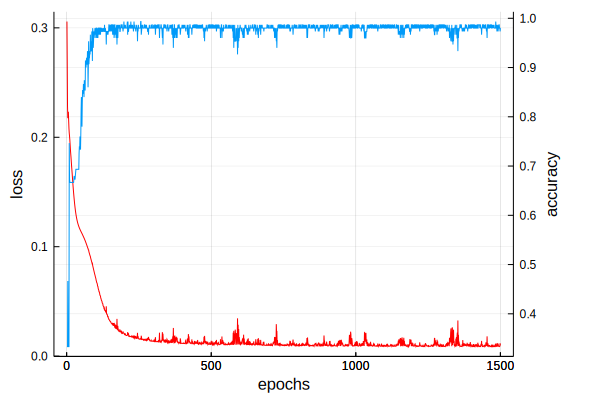

In [12]:
using Plots.PlotMeasures
plot(history_loss, label="Loss", color="red", legend=:false, xlabel="epochs", ylabel="loss", right_margin=[20mm 0mm])
ax = plot!(twinx(), history_acc, label="Accuracy", legend=:false, ylabel="accuracy")